In [1]:
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader, random_split
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sb
import matplotlib.pyplot as plt
from tqdm import tqdm

# Device configuration
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device used: {DEVICE}")

Device used: cuda


In [2]:
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [3]:
BATCH_SIZE = 32
LEARNING_RATE = 0.001
EPOCHS = 7

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(in_features = 128 * 16 * 16, out_features = 1024)
        self.fc2 = nn.Linear(in_features = 1024, out_features=3)

    
    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = self.pool(nn.functional.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [24]:
def init_model(model_name):
    match model_name:
        case "EfficientNet_B0":
            weights = models.EfficientNet_B0_Weights.DEFAULT
            data_transform = weights.transforms()
            model = models.efficientnet_b0(weights=weights)
            num_features = model.classifier[1].in_features
            model.classifier[1] = nn.Linear(num_features, 3) 
        case "ResNet50":
            weights = models.ResNet50_Weights.DEFAULT
            data_transform = weights.transforms()
            model = models.resnet50()
            num_features = model.fc.in_features
            model.fc = nn.Linear(num_features, 3)
        case "CNN":
            model = CNN()
            data_transform = transforms.Compose([
                    transforms.Resize((128, 128)),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
            ])
        case _:
            raise ValueError(f"Model {model_name} is not supported.")
    
    model = model.to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
    return model, data_transform, criterion, optimizer

In [5]:
def init_dataloaders(train_path, test_path, data_transform, val_ratio = 0.1):
    train_dataset = datasets.ImageFolder(root=train_path, transform=data_transform)
    test_dataset = datasets.ImageFolder(root=test_path, transform=data_transform)
    classes = train_dataset.classes
    val_size = int(val_ratio * len(train_dataset))
    train_size = len(train_dataset) - val_size

    set_seed(42)
    val_dataset, train_dataset = random_split(train_dataset, [val_size, train_size])

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    return train_loader, val_loader, test_loader, classes

In [6]:
def train_model(model, model_name, train_loader, val_loader, criterion, optimizer, num_epochs=10):

    best_val_accuracy = 0

    history = {
        "train_loss": [],
        "train_accuracy": [],
        "val_loss": [],
        "val_accuracy": []
    }

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        all_preds = []
        all_labels = []

        # Training phase
        for inputs, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}"):
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_accuracy = accuracy_score(all_labels, all_preds)

        history["train_loss"].append(epoch_loss)
        history["train_accuracy"].append(epoch_accuracy)

        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_preds = []
        val_labels = []
        with torch.inference_mode():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        val_loss = val_running_loss / len(val_loader.dataset)
        val_accuracy = accuracy_score(val_labels, val_preds)

        history["val_loss"].append(val_loss)
        history["val_accuracy"].append(val_accuracy)

        # Print training and validation results
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

        # Save the best model
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), f'{model_name}_best_model.pth')
    
    with open(f'{model_name}_history.json', 'w') as f:
        json.dump(history, f)

    print(f"Training complete for {model_name}. Training stats saved to '{model_name}_history.json'.")

In [12]:
model_names = ["CNN"]

In [25]:
train_path = 'data/afhq/train'
test_path = 'data/afhq/val'

train_loader_classes = {}
test_loaders = {}

for model_name in model_names:
    print(f"Initializing and training model: {model_name}")
    
    model, data_transform, criterion, optimizer = init_model(model_name)
    train_loader, val_loader, test_loader, classes = init_dataloaders(train_path, test_path, data_transform, val_ratio=0.1)

    train_loader_classes[model_name] = classes
    test_loaders[model_name] = test_loader
    
    train_model(model, model_name, train_loader, val_loader, criterion, optimizer, num_epochs=EPOCHS)

Initializing and training model: CNN


Training Epoch 1/7: 100%|██████████| 412/412 [01:00<00:00,  6.82it/s]


Epoch [1/7], Train Loss: 0.3965, Train Accuracy: 0.8341, Val Loss: 0.1975, Val Accuracy: 0.9262


Training Epoch 2/7: 100%|██████████| 412/412 [00:49<00:00,  8.26it/s]


Epoch [2/7], Train Loss: 0.1456, Train Accuracy: 0.9487, Val Loss: 0.1267, Val Accuracy: 0.9522


Training Epoch 3/7: 100%|██████████| 412/412 [00:50<00:00,  8.20it/s]


Epoch [3/7], Train Loss: 0.0768, Train Accuracy: 0.9717, Val Loss: 0.0871, Val Accuracy: 0.9679


Training Epoch 4/7: 100%|██████████| 412/412 [00:50<00:00,  8.11it/s]


Epoch [4/7], Train Loss: 0.0477, Train Accuracy: 0.9809, Val Loss: 0.1064, Val Accuracy: 0.9672


Training Epoch 5/7: 100%|██████████| 412/412 [00:50<00:00,  8.10it/s]


Epoch [5/7], Train Loss: 0.0324, Train Accuracy: 0.9883, Val Loss: 0.1207, Val Accuracy: 0.9624


Training Epoch 6/7: 100%|██████████| 412/412 [00:50<00:00,  8.11it/s]


Epoch [6/7], Train Loss: 0.0161, Train Accuracy: 0.9948, Val Loss: 0.1520, Val Accuracy: 0.9522


Training Epoch 7/7: 100%|██████████| 412/412 [00:52<00:00,  7.80it/s]


Epoch [7/7], Train Loss: 0.0233, Train Accuracy: 0.9919, Val Loss: 0.1313, Val Accuracy: 0.9679
Training complete for CNN. Training stats saved to 'CNN_history.json'.


In [26]:
import itertools
def plot_metrics_from_json(model_names):

    all_train_loss = {}
    all_val_loss = {}
    all_train_acc = {}
    all_val_acc = {}

    for model_name in model_names:
        json_path = f'{model_name}_history.json'
        with open(json_path, 'r') as f:
            data = json.load(f)
        
        all_train_loss[model_name] = data['train_loss']
        all_val_loss[model_name] = data['val_loss']
        all_train_acc[model_name] = data['train_accuracy']
        all_val_acc[model_name] = data['val_accuracy']

    colors = ['b', 'g', 'r']

    plt.figure(figsize=(10, 5))
    for idx, model_name in enumerate(model_names):
        color = colors[idx]
        plt.plot(all_train_loss[model_name], label=f'{model_name} Train Loss', color=color)
        plt.plot(all_val_loss[model_name], label=f'{model_name} Val Loss', color=color, linestyle='--')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Across Models')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot Accuracy (Training and Validation) for all models
    plt.figure(figsize=(10, 5))
    for idx, model_name in enumerate(model_names):
        color = colors[idx]
        plt.plot(all_train_acc[model_name], label=f'{model_name} Train Acc', color=color)
        plt.plot(all_val_acc[model_name], label=f'{model_name} Val Acc', color=color, linestyle='--')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy Across Models')
    plt.legend()
    plt.grid(True)
    plt.show()

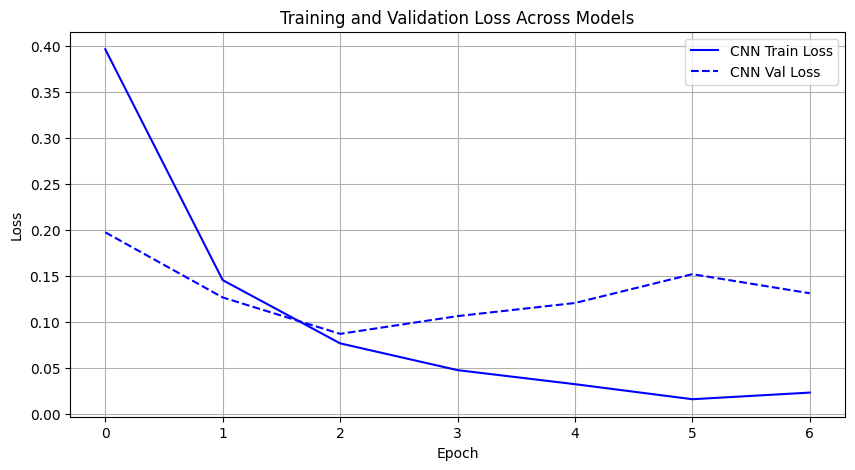

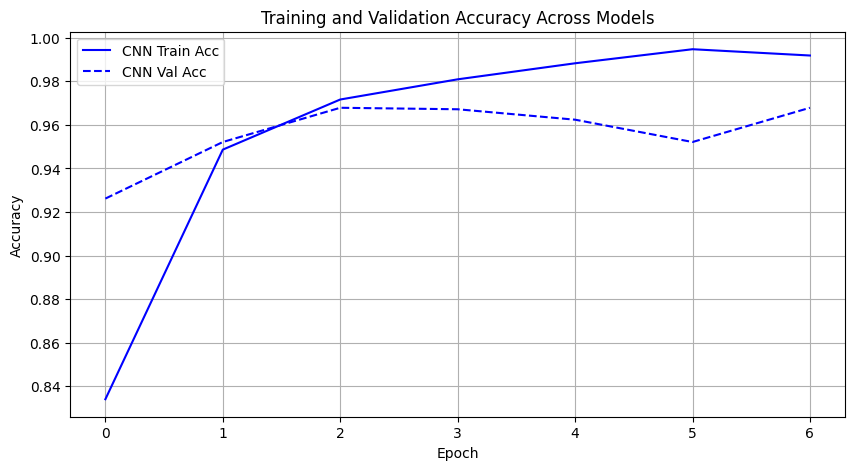

In [27]:
plot_metrics_from_json(model_names)

In [28]:
def test_model(model, model_name, test_loader):
    model.eval()

    test_preds = []
    test_labels = []
    with torch.inference_mode():
        for inputs, labels in tqdm(test_loader, desc="Evaluating Model"):
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            test_preds.extend(preds.cpu().numpy().tolist())
            test_labels.extend(labels.cpu().numpy().tolist())

    results = {
        "test_labels": [test_labels],
        "test_preds": [test_preds]
    }

    with open(f"{model_name}_predictions.json", "w") as f:
        json.dump(results, f)

    print(f"Predictions and labels saved to {model_name}_predictions.json")
    return test_labels, test_preds

In [29]:
for model_name in model_names:
    print(f"Loading and testing model: {model_name}")
    
    model, _, _, _ = init_model(model_name)
    model.load_state_dict(torch.load(f"{model_name}_best_model.pth"))

    test_loader = test_loaders[model_name]
    test_model(model, model_name, test_loader)

Loading and testing model: CNN


/tmp/ipykernel_1253/2822219086.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"{model_name}_best_model.pth"))
Evaluating Model: 100%|█

Predictions and labels saved to CNN_predictions.json


In [30]:
def show_metrics(test_labels, test_preds, classes, model_name):
    # Metrics calculation
    accuracy = accuracy_score(test_labels, test_preds)
    precision = precision_score(test_labels, test_preds, average='weighted')
    recall = recall_score(test_labels, test_preds, average='weighted')
    f1 = f1_score(test_labels, test_preds, average='weighted')
    cm = confusion_matrix(test_labels, test_preds)

    # Display metrics
    print(f"Metrics for {model_name}:")
    print(f'  - Test Accuracy: {accuracy:.4f}')
    print(f'  - Precision: {precision:.4f}')
    print(f'  - Recall: {recall:.4f}')
    print(f'  - F1 Score: {f1:.4f}')
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sb.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

Metrics for CNN:
  - Test Accuracy: 0.9660
  - Precision: 0.9660
  - Recall: 0.9660
  - F1 Score: 0.9660


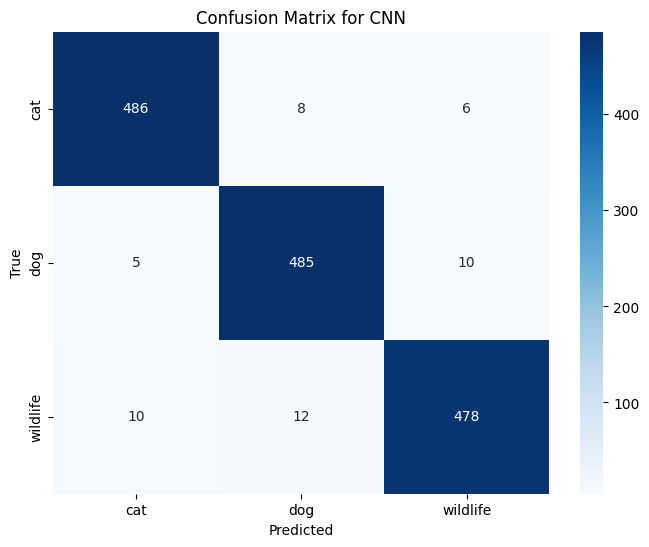

In [31]:
classes = ['cat', 'dog', 'wildlife']
for model_name in model_names:
    with open(f'{model_name}_predictions.json', 'r') as f:
        data = json.load(f)
    test_labels = np.array(data['test_labels']).flatten().tolist()
    test_preds = np.array(data['test_preds']).flatten().tolist()
    # classes = train_loader_classes[model_name]
    show_metrics(test_labels, test_preds, classes, model_name)